In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import ops
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedShuffleSplit

2025-11-28 18:21:22.215999: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-28 18:21:22.216214: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-28 18:21:22.248315: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-28 18:21:23.171619: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
## Configuration des hyperparamètres fournie aux étudiants

embed_dim = 256
num_heads = 8
ff_dim = 1024
epochs = 100
batch_size = 64
oobatake_dim = 1
model_dim = embed_dim + oobatake_dim

kernel_size = 3
pool_size = 2
num_filters = 32

1. Chargez le dataset du TP.

In [ ]:
csv_path = "dataset_large.csv"

df = pd.read_csv(csv_path)

df = df[df["CL"] != 1000004].reset_index(drop=True)

sequences = df["SEQUENCE"].astype(str).tolist()
labels_raw = df["CL"].tolist()

print(f"Nombre total d'exemples : {len(sequences)}")

Nombre total d'exemples : 33677


2. Encodez les sequences d'acides amines en liste d'indices.

In [4]:
chars = sorted({c for seq in sequences for c in seq})
print("Caractères (AA) trouvés dans le dataset :", chars)


char_to_idx = {c: i + 1 for i, c in enumerate(chars)}
idx_to_char = {i + 1: c for i, c in enumerate(chars)}
vocab_size = len(char_to_idx) + 1

encoded_sequences = [[char_to_idx.get(c, 0) for c in seq] for seq in sequences]

maxlen = 256

X = keras.utils.pad_sequences(
    encoded_sequences,
    maxlen=maxlen,
    padding="post",
    truncating="post",
)

Caractères (AA) trouvés dans le dataset : ['*', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


In [5]:
ss_index = {
 'I': 1.10,
 'A': 0.97,
 'L': 0.97,
 'R': 1.08,
 'K': 1.08,
 'N': 0.91,
 'M': 0.91,
 'D': 1.06,
 'F': 1.06,
 'C': 0.95,
 'P': 0.95,
 'Q': 1.12,
 'S': 1.12,
 'E': 1.01,
 'T': 1.01,
 'G': 0.91,
 'W': 0.91,
 'H': 1.01,
 'Y': 1.01,
 'V': 1.10
}

ss_dim = 1

ss_matrix = np.zeros((vocab_size, ss_dim), dtype="float32")
for aa, idx in char_to_idx.items():
    value = ss_index.get(aa, 0.0)
    ss_matrix[idx, 0] = value

3. Encodez les valeurs des classes de votre dataset puis preparez vos sets train et validation (70/30). Vous utiliserez un StratifiedShuffleSplit afin d'automatiser la repartition des classes et avoir quelque chose d'homogene.

In [6]:
unique_classes = sorted(df["CL"].unique())
cl_to_idx = {cl: i for i, cl in enumerate(unique_classes)}
idx_to_cl = {i: cl for cl, i in cl_to_idx.items()}

y = df["CL"].map(cl_to_idx).values
num_classes = len(unique_classes)

x_train = X
y_train = y

4. Construisez un CNN basique que vous entrainerez sur le dataset. Vous utiliserez un Adam optimizer et une fonction de loss 

In [ ]:
inputs_cnn = keras.Input(shape=(maxlen,))

ss_emb_cnn = layers.Embedding(
    input_dim=vocab_size,
    output_dim=ss_dim,
    input_length=maxlen,
    weights=[ss_matrix],
    trainable=True,
)

x = ss_emb_cnn(inputs_cnn)

x = layers.Conv1D(filters=num_filters, kernel_size=kernel_size, activation="relu")(x)
x = layers.MaxPooling1D(pool_size=pool_size)(x)

x = layers.Conv1D(filters=num_filters, kernel_size=kernel_size, activation="relu")(x)
x = layers.MaxPooling1D(pool_size=pool_size)(x)

x = layers.Flatten()(x)

x = layers.Dropout(0.5)(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs_cnn = layers.Dense(num_classes, activation="softmax")(x)

model_cnn = keras.Model(inputs_cnn, outputs_cnn, name="cnn_1d_protein")

model_cnn.summary()

model_cnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history_cnn = model_cnn.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

/home/thomas/42Cursus/upc_tp/tp_imdb/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-11-28 18:21:24.534690: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "cnn_1d_protein"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 256, 1)         │            22 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 254, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 127, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 125, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 62, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1984)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1984)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        31,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,082 (137.04 KB)

 Trainable params: 35,082 (137.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3887 - loss: 1.2984 - val_accuracy: 0.3882 - val_loss: 1.2773
Epoch 2/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4137 - loss: 1.2633 - val_accuracy: 0.3925 - val_loss: 1.2635
Epoch 3/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4252 - loss: 1.2491 - val_accuracy: 0.4124 - val_loss: 1.2544
Epoch 4/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4367 - loss: 1.2356 - val_accuracy: 0.4225 - val_loss: 1.2441
Epoch 5/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4438 - loss: 1.2187 - val_accuracy: 0.4379 - val_loss: 1.2364
Epoch 6/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4591 - loss: 1.2037 - val_accuracy: 0.4489 - val_loss: 1.2084
Epoch 7/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4677 - loss: 1.1879 - val_accuracy: 0.4516 - val_loss: 1.2101
Epoch 8/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4714 - loss: 1.1775 - val_accu

6. Construisez nouveau modele se basant sur une couche de self attention et dont la sortie sera envoyee dans un CNN classique. Vous utiliserez un adam optimizer ainsi qu'une fonction de loss sparse categorical crossentropy. Un callback d'early stopping pourra etre implemente.

In [8]:
inputs_att = keras.Input(shape=(maxlen,), name="inputs_att")

x_att = layers.CategoryEncoding(
    num_tokens=vocab_size,
    output_mode="one_hot",
    name="one_hot_encoding"
)(inputs_att)

mask = ops.not_equal(inputs_att, 0)

att_layer = layers.Attention(name="self_attention")
x_att = att_layer([x_att, x_att], mask=[mask, mask])

x_att = layers.Conv1D(filters=num_filters, kernel_size=kernel_size, activation="relu")(x_att)
x_att = layers.MaxPooling1D(pool_size=pool_size)(x_att)

x_att = layers.Flatten()(x_att)

x_att = layers.Dropout(0.5)(x_att)
x_att = layers.Dense(16, activation="relu")(x_att)
x_att = layers.Dropout(0.5)(x_att)

outputs_att = layers.Dense(num_classes, activation="softmax")(x_att)

model_att_cnn = keras.Model(inputs_att, outputs_att, name="self_attention_cnn_onehot")

model_att_cnn.summary()

opt = Adam(learning_rate=3e-4, clipnorm=1.0)
loss = keras.losses.SparseCategoricalCrossentropy()

model_att_cnn.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

history_att_cnn = model_att_cnn.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split =0.2,
    callbacks=[early_stop],
)


/home/thomas/42Cursus/upc_tp/tp_imdb/venv/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "self_attention_cnn_onehot"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs_att          │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ one_hot_encoding    │ (None, 256, 22)   │          0 │ inputs_att[0][0]  │
│ (CategoryEncoding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 256)       │          0 │ inputs_att[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention      │ (None, 256, 22)   │          0 │ one_hot_encoding… │
│ (Attention)         │                   │            │ one_hot_encoding… │
│                     │                   │            │ not_equal[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 254, 32)   │      2,144 │ self_attention[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 127, 32)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4064)      │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4064)      │          0 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │     65,040 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │         68 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,252 (262.70 KB)

 Trainable params: 67,252 (262.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4324 - loss: 1.2073 - val_accuracy: 0.4967 - val_loss: 1.1317
Epoch 2/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4998 - loss: 1.1185 - val_accuracy: 0.5515 - val_loss: 1.0664
Epoch 3/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5326 - loss: 1.0710 - val_accuracy: 0.5689 - val_loss: 1.0231
Epoch 4/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5449 - loss: 1.0436 - val_accuracy: 0.5885 - val_loss: 0.9831
Epoch 5/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5506 - loss: 1.0280 - val_accuracy: 0.5958 - val_loss: 0.9697
Epoch 6/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5573 - loss: 1.0180 - val_accuracy: 0.5963 - val_loss: 0.9621
Epoch 7/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5636 - loss: 1.0080 - val_accuracy: 0.6053 - val_loss: 0.9531
Epoch 8/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5686 - loss: 0.9982 - val_accu

7. Évaluez les performances de vos deux modèles (CNN et Self-attention + CNN) sur le jeu de validation et comparez-les en les affichant.

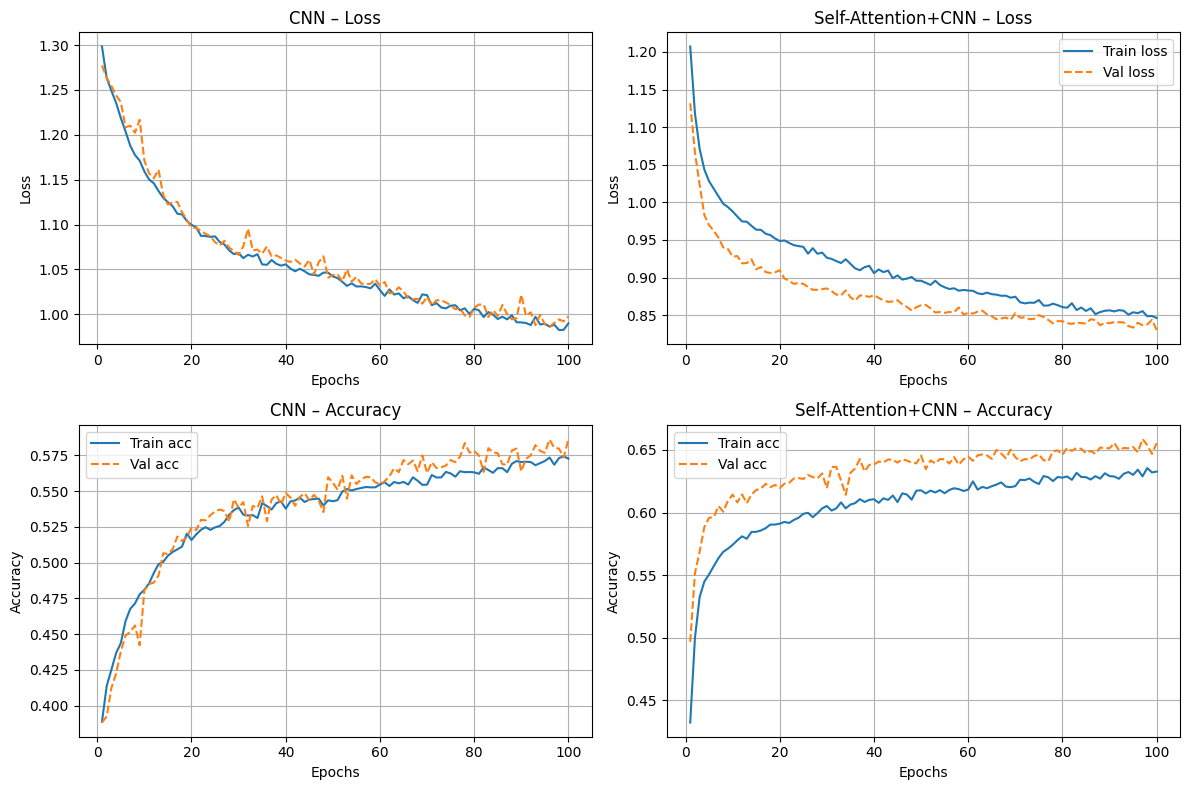

In [ ]:
def plot_history_panels(history_cnn, history_transfo, out_path="training_panels.png"):

    c_acc = history_cnn.history.get("accuracy", [])
    c_val_acc = history_cnn.history.get("val_accuracy", [])
    c_loss = history_cnn.history.get("loss", [])
    c_val_loss = history_cnn.history.get("val_loss", [])
    c_epochs = range(1, len(c_acc) + 1)

    a_acc = history_att_cnn.history.get("accuracy", [])
    a_val_acc = history_att_cnn.history.get("val_accuracy", [])
    a_loss = history_att_cnn.history.get("loss", [])
    a_val_loss = history_att_cnn.history.get("val_loss", [])
    a_epochs = range(1, len(a_acc) + 1)

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    ax = axs[0, 0]
    ax.plot(c_epochs, c_loss, label="Train loss")
    ax.plot(c_epochs, c_val_loss, linestyle="--", label="Val loss")
    ax.set_title("CNN – Loss")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.grid(True)

    ax = axs[0, 1]
    ax.plot(a_epochs, a_loss, label="Train loss")
    ax.plot(a_epochs, a_val_loss, linestyle="--", label="Val loss")
    ax.set_title("Self-Attention+CNN – Loss")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.grid(True)
    ax.legend()

    ax = axs[1, 0]
    ax.plot(c_epochs, c_acc, label="Train acc")
    ax.plot(c_epochs, c_val_acc, linestyle="--", label="Val acc")
    ax.set_title("CNN – Accuracy")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.grid(True)
    ax.legend()

    ax = axs[1, 1]
    ax.plot(a_epochs, a_acc, label="Train acc")
    ax.plot(a_epochs, a_val_acc, linestyle="--", label="Val acc")
    ax.set_title("Self-Attention+CNN – Accuracy")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
plot_history_panels(history_cnn, history_att_cnn, out_path="training_panels_one_hot.png")